# Smart Search: Document Matching

### Imports

In [1]:
import itertools as it
import logging
import multiprocessing as mp
from collections.abc import (
    Iterable,
    Sequence,
)
from pathlib import Path

import pandas as pd
import more_itertools as mit
import gensim
import wordcloud
import joblib
import gensim.downloader
import nltk
import unidecode
from gensim.models import (
    doc2vec,
)
from sklearn import (
    dummy,
    decomposition,
    ensemble,
    preprocessing,
    metrics,
    neighbors,
    model_selection,
    naive_bayes,
    pipeline,
    linear_model,
    tree,
    svm,
)

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%aimport autoreply.dataset
%aimport autoreply.constants
%aimport autoreply.misc_data

%aimport autoreply.modeling
%aimport autoreply.modeling.eda
%aimport autoreply.modeling.model
%aimport autoreply.modeling.preprocess
%aimport autoreply.modeling.evaluate


from autoreply import (
    misc_data,
    constants as C,
    modeling,
)

In [4]:
logging.basicConfig(level=logging.WARNING, force=True)

## EDA

In [5]:
db = misc_data.DBResult.load()

### Data view

#### Title

In [6]:
db.title

,title_id,title
0,0,Frédéric_Chopin
1,1,IPod
2,2,The_Legend_of_Zelda:_Twilight_Princess
3,3,Spectre_(2015_film)
4,4,2008_Sichuan_earthquake
...,...,...
289,289,"Richmond,_Virginia"
290,290,Infection
291,291,Kathmandu
292,292,Myocardial_infarction


#### Paragraph

In [7]:
db.paragraph

,title_id,para_id,context
0,0,0,Frédéric François Chopin (/ˈʃoʊpæn/; French pr...
1,0,1,At the age of 21 he settled in Paris. Thereaft...
2,0,2,All of Chopin's compositions include the piano...
3,0,3,"In his native Poland, in France, where he comp..."
4,0,4,"Fryderyk Chopin was born in Żelazowa Wola, 46 ..."
...,...,...,...
12826,293,24,Isaac Newton (1643–1727) inherited Descartes' ...
12827,293,25,"There is an entire literature concerning the ""..."
12828,293,26,In the late 19th century with the discovery of...
12829,293,27,These quarks and leptons interact through four...


[Text(0.5, 0, 'Paragraphs'), Text(0.5, 1.0, 'Paragraph Count Distribution')]

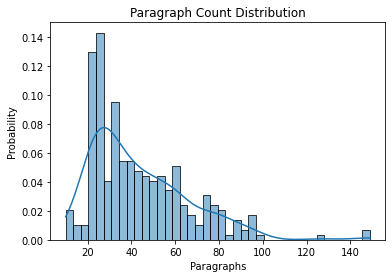

In [8]:
ax = sns.histplot(x=db.paragraph.groupby('title_id').size(), stat='probability', bins=40, kde=True)
ax.set(xlabel='Paragraphs', title='Paragraph Count Distribution')
#plt.savefig('para-count.png')

[Text(0.5, 1.0, 'Paragraph Count by Title')]

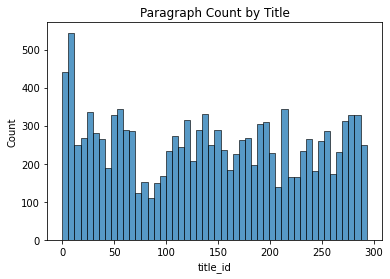

In [9]:
ax = sns.histplot(db.paragraph.title_id, bins=50)
ax.set(title='Paragraph Count by Title')
#plt.savefig('para-count-title.png')

In [10]:
wc2 = wordcloud.WordCloud().generate(' '.join(db.paragraph.context.apply(modeling.preprocess.main).str.join(' ').to_list()))

(-0.5, 399.5, 199.5, -0.5)

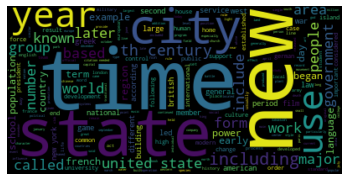

In [11]:
plt.imshow(wc2, interpolation='bilinear')
plt.axis('off')

In [12]:
_word_counts = Counter(it.chain.from_iterable(db.paragraph.context.apply(modeling.preprocess.main).to_list()))

In [40]:
words = db.paragraph.context.apply(modeling.preprocess.main).to_list()

In [41]:
words[0]

['frederic',
 'francois',
 'chopin',
 'soupaen',
 'french',
 'pronunciation',
 'fre',
 'rik',
 'fra',
 'swa',
 'pe',
 'february',
 'march',
 'october',
 'born',
 'fryderyk',
 'franciszek',
 'chopin',
 'polish',
 'french',
 'citizenship',
 'birth',
 'father',
 'composer',
 'virtuoso',
 'pianist',
 'romantic',
 'era',
 'wrote',
 'primarily',
 'solo',
 'piano',
 'gained',
 'maintained',
 'renown',
 'worldwide',
 'leading',
 'musicians',
 'era',
 'poetic',
 'genius',
 'based',
 'professional',
 'technique',
 'equal',
 'generation',
 'chopin',
 'born',
 'duchy',
 'warsaw',
 'grew',
 'warsaw',
 'congress',
 'poland',
 'child',
 'prodigy',
 'completed',
 'musical',
 'education',
 'composed',
 'earlier',
 'works',
 'warsaw',
 'leaving',
 'poland',
 'age',
 'month',
 'outbreak',
 'november',
 'uprising']

In [13]:
_word_counts.most_common(20)

[('city', 3060),
 ('new', 2990),
 ('th', 2179),
 ('world', 2000),
 ('time', 1915),
 ('state', 1839),
 ('states', 1814),
 ('united', 1703),
 ('century', 1701),
 ('war', 1677),
 ('people', 1501),
 ('known', 1460),
 ('years', 1414),
 ('including', 1397),
 ('use', 1376),
 ('government', 1292),
 ('north', 1258),
 ('early', 1250),
 ('number', 1233),
 ('called', 1215)]

[Text(0.5, 0, 'Word Frequency (log_scaled)'),
 Text(0.5, 1.0, 'Paragraph Count Distribution')]

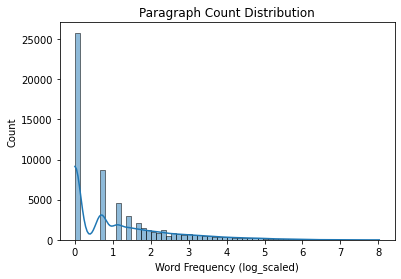

In [16]:
ax = sns.histplot(x=np.log(list(_word_counts.values())), bins=60, kde=True)
ax.set(xlabel='Word Frequency (log_scaled)', title='Paragraph Count Distribution')


#### Title/Para

In [9]:
modeling.eda.summary(db)

,title,para_id,question
title_id,,,
0,Frédéric_Chopin,82,697
1,IPod,60,327
2,The_Legend_of_Zelda:_Twilight_Princess,32,374
3,Spectre_(2015_film),43,462
4,2008_Sichuan_earthquake,77,521
...,...,...,...
289,"Richmond,_Virginia",61,291
290,Infection,30,290
291,Kathmandu,58,276


#### Question

In [10]:
db.ques_ans

,title_id,para_id,ques_ans_id,question,is_impossible
0,0,0,56cbd2356d243a140015ed66,What was Frédéric's nationalities?,False
1,0,0,56cbd2356d243a140015ed67,In what era was Frédéric active in?,False
2,0,0,56cbd2356d243a140015ed68,For what instrument did Frédéric write primari...,False
3,0,0,56cbd2356d243a140015ed69,In what area was Frédéric born in?,False
4,0,0,56cbd2356d243a140015ed6a,At what age did Frédéric depart from Poland?,False
...,...,...,...,...,...
86563,293,28,5a7e070b70df9f001a875439,Physics has broadly agreed on the definition o...,True
86564,293,28,5a7e070b70df9f001a87543a,Who coined the term partonic matter?,True
86565,293,28,5a7e070b70df9f001a87543b,What is another name for anti-matter?,True
86566,293,28,5a7e070b70df9f001a87543c,Matter usually does not need to be used in con...,True


[Text(0.5, 0, 'Questions'), Text(0.5, 1.0, 'Question Distribution')]

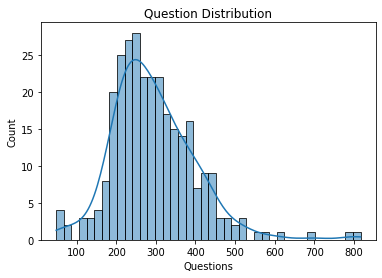

In [18]:
ax = sns.histplot(x=db.ques_ans.groupby('title_id').size(), bins=40, kde=True)
ax.set(xlabel='Questions', title='Question Distribution')
# plt.savefig('question-count.png')

[Text(0.5, 1.0, 'Question Count by Title')]

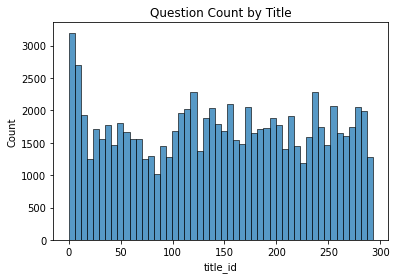

In [19]:
ax = sns.histplot(db.ques_ans.title_id, bins=50)
ax.set(title='Question Count by Title')
# plt.savefig('question-count-title.png')

#### Answer 

In [20]:
db.answer

,ques_ans_id,ans_id,answer,answer_start
0,56cbd2356d243a140015ed66,0,Polish and French,182
1,56cbd2356d243a140015ed67,0,Romantic era,276
2,56cbd2356d243a140015ed68,0,solo piano,318
3,56cbd2356d243a140015ed69,0,Duchy of Warsaw,559
4,56cbd2356d243a140015ed6a,0,20,777
...,...,...,...,...
58596,5735d259012e2f140011a09d,0,Oregon,229
58597,5735d259012e2f140011a09e,0,Rangoon,414
58598,5735d259012e2f140011a09f,0,Minsk,476
58599,5735d259012e2f140011a0a0,0,1975,199


## Train Test

In [21]:
train, dev = model_selection.train_test_split(
    db.paragraph, stratify=db.paragraph.title_id
)

In [22]:
test = db.ques_ans

In [23]:
def make_report(y_true: np.ndarray, y_pred) -> pd.DataFrame:
    return pd.DataFrame(
        metrics.classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    ).T

In [24]:
def summarize_report(class_report: pd.DataFrame) -> pd.DataFrame:
    prec_rec_f1_df = class_report.iloc[:-3]
    support = np.clip(np.log(prec_rec_f1_df['support'] + 1e-6), 0, None).to_numpy()

    prec_rec_f1 = (
        prec_rec_f1_df.loc[:, :'f1-score'] * support.reshape(-1, 1)
    ).sum() / support.sum()
    
    rest = class_report.iloc[-3:, 0]
    return pd.concat([prec_rec_f1, rest]).to_frame('Values')

## Doc2Vec

In [25]:
def make_docs(para: pd.DataFrame) -> list[doc2vec.TaggedDocument]:
    documents = [
        doc2vec.TaggedDocument(modeling.preprocess.main(txt), [title])
        for title, para_, txt in para.to_numpy()
    ]
    return documents


# documents = [doc2vec.TaggedDocument(preprocess(txt), [f'{title}-{para}']) for title, para, txt in db.paragraph.to_numpy()]

In [26]:
train

,title_id,para_id,context
9315,211,6,"Of the remaining land area, the state of Alask..."
10271,237,12,Frederick saw Saxony and Polish west Prussia a...
8292,187,14,The modern period of the kingdom of Galicia be...
3034,54,47,Horizontal gene transfer refers to the transfe...
889,10,105,As one of the most successful shows on U.S. te...
...,...,...,...
6053,133,21,"In intelligent mammals, such as primates, the ..."
5155,115,4,Other states with long histories of no death p...
12274,282,20,Lower interest rates encouraged borrowing. Fro...
11285,261,4,The majority of studies indicate antibiotics d...


In [27]:
train_docs = make_docs(train)

#### Model 1

In [111]:
# doc_model = doc2vec.Doc2Vec(vector_size=100)
# doc_model.build_vocab(train_docs)
# doc_model.train(train_docs, total_examples=doc_model.corpus_count, epochs=10)

In [409]:
# doc_model.save('doc2vec-100.joblib')

In [30]:
doc_model = doc2vec.Doc2Vec.load('.models/doc2vec-100.joblib')

In [31]:
vecs = [doc_model.infer_vector(doc.words) for doc in train_docs]

#### Glove

In [32]:
glove = gensim.downloader.load('glove-wiki-gigaword-100')

In [33]:
tokenized = train.context.apply(modeling.preprocess.main)

In [34]:
tokenized

9315     [remaining, land, area, state, alaska, owns, m...
10271    [frederick, saw, saxony, polish, west, prussia...
8292     [modern, period, kingdom, galicia, began, murd...
3034     [horizontal, gene, transfer, refers, transfer,...
889      [successful, shows, television, history, ameri...
                               ...                        
6053     [intelligent, mammals, primates, cerebrum, lar...
5155     [states, long, histories, death, penalty, incl...
12274    [lower, rates, encouraged, borrowing, federal,...
11285    [majority, studies, indicate, antibiotics, int...
9209     [june, king, queen, toured, canada, united, st...
Name: context, Length: 9623, dtype: object

In [35]:
def to_vec(doc: list[str]) -> np.ndarray:
    words = [glove[word] for word in doc if word in glove]
    arr = np.array(words).mean(axis=0)
    return arr if arr.shape == (100,) else np.zeros(100)

In [36]:
doc_rep = np.array([to_vec(doc) for doc in tokenized])

In [37]:
doc_rep.shape

(9623, 100)

#### KNN

In [38]:
from sklearn import model_selection

In [79]:
_knn_clf = model_selection.GridSearchCV(neighbors.KNeighborsClassifier(), {'n_neighbors': [1, 5, 10]})

In [86]:
_knn_clf.fit(doc_rep, train.title_id)

In [81]:
_knn_clf.cv_results_

{'mean_fit_time': array([0.00487213, 0.00374107, 0.00494299]),
 'std_fit_time': array([0.00258252, 0.00240235, 0.00216516]),
 'mean_score_time': array([0.52488923, 0.72373657, 0.81227245]),
 'std_score_time': array([0.05803121, 0.02901561, 0.11851293]),
 'param_n_neighbors': masked_array(data=[1, 5, 10],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 1}, {'n_neighbors': 5}, {'n_neighbors': 10}],
 'split0_test_score': array([0.54493506, 0.55064935, 0.54909091]),
 'split1_test_score': array([0.56467532, 0.56675325, 0.54857143]),
 'split2_test_score': array([0.54493506, 0.55220779, 0.55428571]),
 'split3_test_score': array([0.55093555, 0.55873181, 0.55925156]),
 'split4_test_score': array([0.56704782, 0.56704782, 0.56185031]),
 'mean_test_score': array([0.55450576, 0.559078  , 0.55460998]),
 'std_test_score': array([0.00955684, 0.00693958, 0.00531029]),
 'rank_test_score': array([3, 1, 2])}

In [85]:
_knn_clf.best_params_

{'n_neighbors': 5}

In [11]:
knn = neighbors.KNeighborsClassifier()

In [19]:
knn.fit(doc_rep, train.title_id)

KNeighborsClassifier()

In [20]:
make_report(train.title_id, knn.predict(doc_rep))

C:\Users\wb570819\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


,precision,recall,f1-score,support
0,0.821918,0.983607,0.895522,61.000000
1,0.833333,0.888889,0.860215,45.000000
2,0.777778,0.875000,0.823529,24.000000
3,0.707317,0.906250,0.794521,32.000000
4,0.779412,0.913793,0.841270,58.000000
...,...,...,...,...
292,1.000000,0.850000,0.918919,20.000000
293,0.950000,0.863636,0.904762,22.000000
accuracy,0.739686,0.739686,0.739686,0.739686
macro avg,0.759980,0.734038,0.731159,9623.000000


In [22]:
tokenized_dev = dev.context.apply(modeling.preprocess.main)

In [23]:
dev_doc_rep = np.array([to_vec(doc) for doc in tokenized_dev])

In [24]:
knn_pred = knn.predict(dev_doc_rep)

C:\Users\wb570819\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [25]:
summarize_report(make_report(dev.title_id, knn_pred))

,Values
precision,0.590731
recall,0.576760
f1-score,0.561247
accuracy,0.582294
macro avg,0.591890
weighted avg,0.588858


In [48]:
tokenized_test = test['question'].apply(modeling.preprocess.main)

In [49]:
vecs = np.array([to_vec(doc) for doc in tokenized_test])

C:\Users\wb570819\AppData\Local\Temp/ipykernel_12636/79307065.py:3: RuntimeWarning: Mean of empty slice.
  arr = np.array(words).mean(axis=0)
C:\Users\wb570819\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [31]:
summarize_report(make_report(test.title_id, knn.predict(vecs)))

,Values
precision,0.440212
recall,0.398239
f1-score,0.394549
accuracy,0.403636
macro avg,0.438653
weighted avg,0.445588


In [ ]:
pred_tags = modeling.evaluate.results(train['context'], doc_model, epochs=5)

In [ ]:
summarize_report(make_report(train.title_id, pred_tags))

,Values
precision,0.727777
recall,0.679213
f1-score,0.663283
accuracy,0.665697
macro avg,0.704003
weighted avg,0.779773


In [417]:
dev_tags = modeling.evaluate.results(dev['context'], doc_model, epochs=5)

In [418]:
summarize_report(make_report(dev.title_id, dev_tags))

,Values
precision,0.752931
recall,0.686947
f1-score,0.675623
accuracy,0.675810
macro avg,0.716798
weighted avg,0.791727


In [113]:
test_tags = modeling.evaluate.results(test['question'], doc_model, epochs=5)

In [33]:
# _N = os.cpu_count()
# sections = mit.distribute(_N, db.paragraph['context'])
# with mp.Pool(_N) as pool:
#     res = list(mit.flatten(pool.map(modeling.evaluate.Eval(doc_model1), sections)))

In [114]:
summarize_report(make_report(test.title_id, test_tags))

,Values
precision,0.374274
recall,0.285664
f1-score,0.301881
accuracy,0.292464
macro avg,0.364751
weighted avg,0.415014


TODO: Plot knee-curve for difference K's

#### Logistic

In [45]:
# log_clf = pipeline.make_pipeline(preprocessing.StandardScaler(), linear_model.LogisticRegressionCV())
log_clf = joblib.load('.models/log_clf-glove.joblib')

In [527]:
# log_clf.fit(doc_rep, train.title_id)

In [103]:
summarize_report(make_report(train.title_id, log_clf.predict(doc_rep)))

,Values
precision,0.919954
recall,0.913600
f1-score,0.915519
accuracy,0.913540
macro avg,0.921493
weighted avg,0.915583


In [104]:
summarize_report(make_report(dev.title_id, log_clf.predict(dev_doc_rep)))

,Values
precision,0.931181
recall,0.922438
f1-score,0.923558
accuracy,0.923317
macro avg,0.933765
weighted avg,0.928151


In [105]:
summarize_report(make_report(test.title_id, log_clf.predict(vecs)))

,Values
precision,0.484525
recall,0.444203
f1-score,0.448767
accuracy,0.451252
macro avg,0.483090
weighted avg,0.491515


In [539]:
joblib.dump(log_clf, 'log_clf-glove.joblib')

['log_clf-glove.joblib']

### SVM

In [516]:
svm_clf =  pipeline.make_pipeline(preprocessing.StandardScaler(), svm.SVC())

In [517]:
svm_clf.fit(doc_rep, train.title_id)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())])

In [524]:
summarize_report(make_report(train.title_id, svm_clf.predict(doc_rep)))

,Values
precision,0.915209
recall,0.893094
f1-score,0.897417
accuracy,0.904500
macro avg,0.917645
weighted avg,0.909571


In [525]:
summarize_report(make_report(dev.title_id, svm_clf.predict(dev_doc_rep)))

,Values
precision,0.696622
recall,0.671357
f1-score,0.665958
accuracy,0.684539
macro avg,0.701720
weighted avg,0.691552


In [526]:
summarize_report(make_report(test.title_id, svm_clf.predict(vecs)))

,Values
precision,0.633920
recall,0.163917
f1-score,0.208444
accuracy,0.172708
macro avg,0.634121
weighted avg,0.631787


In [540]:
joblib.dump(svm_clf, 'svm_clf.joblib')

['svm_clf.joblib']

#### Linear SVM

In [528]:
lin_svm_clf =  pipeline.make_pipeline(preprocessing.StandardScaler(), svm.LinearSVC())

In [529]:
lin_svm_clf.fit(doc_rep, train.title_id)

C:\Users\wb570819\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])

In [530]:
summarize_report(make_report(train.title_id, lin_svm_clf.predict(doc_rep)))

,Values
precision,0.973958
recall,0.975428
f1-score,0.974177
accuracy,0.969552
macro avg,0.975507
weighted avg,0.969495


In [531]:
summarize_report(make_report(dev.title_id, lin_svm_clf.predict(dev_doc_rep)))

,Values
precision,0.675320
recall,0.671271
f1-score,0.662613
accuracy,0.679239
macro avg,0.666313
weighted avg,0.685900


In [532]:
summarize_report(make_report(test.title_id, lin_svm_clf.predict(vecs)))

,Values
precision,0.382293
recall,0.327436
f1-score,0.326767
accuracy,0.336914
macro avg,0.380520
weighted avg,0.394289


In [541]:
joblib.dump(lin_svm_clf, 'lin_svm_clf.joblib')

['lin_svm_clf.joblib']

### Decision Tree

In [556]:
dt_clf =  pipeline.make_pipeline(tree.DecisionTreeClassifier())

In [557]:
dt_clf.fit(doc_rep, train.title_id)

Pipeline(steps=[('decisiontreeclassifier', DecisionTreeClassifier())])

In [558]:
summarize_report(make_report(train.title_id, dt_clf.predict(doc_rep)))

,Values
precision,1.0
recall,1.0
f1-score,1.0
accuracy,1.0
macro avg,1.0
weighted avg,1.0


In [559]:
summarize_report(make_report(dev.title_id, dt_clf.predict(dev_doc_rep)))

,Values
precision,0.194431
recall,0.190415
f1-score,0.187024
accuracy,0.201060
macro avg,0.185774
weighted avg,0.204161


In [560]:
summarize_report(make_report(test.title_id, dt_clf.predict(vecs)))

,Values
precision,0.070613
recall,0.071358
f1-score,0.065516
accuracy,0.076044
macro avg,0.069333
weighted avg,0.076410


### AdaBoost

In [561]:
boost_clf =  pipeline.make_pipeline(ensemble.AdaBoostClassifier())

In [562]:
boost_clf.fit(doc_rep, train.title_id)

Pipeline(steps=[('adaboostclassifier', AdaBoostClassifier())])

In [563]:
summarize_report(make_report(train.title_id, boost_clf.predict(doc_rep)))

,Values
precision,0.001826
recall,0.010096
f1-score,0.001398
accuracy,0.018290
macro avg,0.001763
weighted avg,0.001865


In [564]:
summarize_report(make_report(dev.title_id, boost_clf.predict(dev_doc_rep)))

,Values
precision,0.000521
recall,0.010577
f1-score,0.000903
accuracy,0.017768
macro avg,0.000506
weighted avg,0.000584


In [565]:
summarize_report(make_report(test.title_id, boost_clf.predict(vecs)))

,Values
precision,0.000429
recall,0.007310
f1-score,0.000755
accuracy,0.009519
macro avg,0.000417
weighted avg,0.000476


In [32]:
rf_clf =  pipeline.make_pipeline(ensemble.RandomForestClassifier())

In [34]:
rf_clf.fit(doc_rep, train.title_id)

Pipeline(steps=[('randomforestclassifier', RandomForestClassifier())])

In [35]:
summarize_report(make_report(train.title_id, rf_clf.predict(doc_rep)))

,Values
precision,1.0
recall,1.0
f1-score,1.0
accuracy,1.0
macro avg,1.0
weighted avg,1.0


In [36]:
summarize_report(make_report(dev.title_id, rf_clf.predict(dev_doc_rep)))

,Values
precision,0.591716
recall,0.557002
f1-score,0.543192
accuracy,0.580112
macro avg,0.596283
weighted avg,0.581371


In [37]:
summarize_report(make_report(test.title_id, rf_clf.predict(vecs)))

,Values
precision,0.362301
recall,0.258670
f1-score,0.246752
accuracy,0.272052
macro avg,0.363120
weighted avg,0.358205


## Arbitrary

In [49]:
# dbs = modeling.eda.filter_db(db, range(5))
dbs = db

In [45]:
_STOPWORDS = set(nltk.corpus.stopwords.words('english'))

In [50]:
test = dbs.ques_ans

### KNN

In [87]:
tf_knn_clf = pipeline.make_pipeline(
    feature_extraction.text.TfidfVectorizer(
    strip_accents='ascii',
    stop_words=_STOPWORDS,
    ngram_range=(1, 2),
    min_df=5,
),
decomposition.TruncatedSVD(100, random_state=42),
neighbors.KNeighborsClassifier(),

)

In [88]:
tf_knn_clf.fit(train['context'], train['title_id'])

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(min_df=5, ngram_range=(1, 2),
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...},
                                 strip_accents='ascii')),
                ('truncatedsvd',
                 TruncatedSVD(n_components=100, random_state=42)),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [89]:
make_report(train.title_id, tf_knn_clf.predict(train['context']))

C:\Users\wb570819\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


,precision,recall,f1-score,support
0,0.952381,0.983607,0.967742,61.000000
1,0.750000,0.866667,0.804124,45.000000
2,0.633333,0.791667,0.703704,24.000000
3,0.474576,0.875000,0.615385,32.000000
4,0.481132,0.879310,0.621951,58.000000
...,...,...,...,...
292,0.937500,0.750000,0.833333,20.000000
293,0.869565,0.909091,0.888889,22.000000
accuracy,0.765458,0.765458,0.765458,0.765458
macro avg,0.769742,0.737912,0.734723,9623.000000


In [90]:
make_report(dev.title_id, tf_knn_clf.predict(dev['context']))

C:\Users\wb570819\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


,precision,recall,f1-score,support
0,1.000000,0.952381,0.975610,21.00000
1,0.705882,0.800000,0.750000,15.00000
2,0.466667,0.875000,0.608696,8.00000
3,0.285714,0.727273,0.410256,11.00000
4,0.394737,0.789474,0.526316,19.00000
...,...,...,...,...
292,0.750000,0.500000,0.600000,6.00000
293,0.666667,0.857143,0.750000,7.00000
accuracy,0.634040,0.634040,0.634040,0.63404
macro avg,0.634690,0.598734,0.585421,3208.00000


In [91]:
make_report(test.title_id, tf_knn_clf.predict(test['question']))

C:\Users\wb570819\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


,precision,recall,f1-score,support
0,0.985743,0.694405,0.814815,697.000000
1,0.699647,0.605505,0.649180,327.000000
2,0.186589,0.513369,0.273699,374.000000
3,0.176517,0.484848,0.258810,462.000000
4,0.056641,0.383877,0.098717,521.000000
...,...,...,...,...
292,0.290323,0.071429,0.114650,126.000000
293,0.509434,0.190141,0.276923,142.000000
accuracy,0.274732,0.274732,0.274732,0.274732
macro avg,0.447759,0.259174,0.280567,86568.000000


#### Logistic

In [57]:
tf_log_clf = pipeline.make_pipeline(
    feature_extraction.text.TfidfVectorizer(
    strip_accents='ascii',
    stop_words=_STOPWORDS,
    ngram_range=(1, 2),
    min_df=5,
),
decomposition.TruncatedSVD(100, random_state=42),
linear_model.LogisticRegressionCV(),

)

In [39]:
# tf_log_clf = linear_model.LogisticRegressionCV()
tf_log_clf = joblib.load('tf-log_clf.joblib')

In [59]:
tf_log_clf.fit(train['context'], train['title_id'])

C:\Users\wb570819\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\wb570819\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.or

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(min_df=5, ngram_range=(1, 2),
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...},
                                 strip_accents='ascii')),
                ('truncatedsvd',
                 TruncatedSVD(n_components=100, random_state=42)),
                ('logisticregressioncv', LogisticRegressionCV())])

In [62]:
make_report(train.title_id, tf_log_clf.predict(train['context']))

,precision,recall,f1-score,support
0,1.000000,1.000000,1.000000,61.000000
1,0.978261,1.000000,0.989011,45.000000
2,1.000000,1.000000,1.000000,24.000000
3,0.969697,1.000000,0.984615,32.000000
4,0.948276,0.948276,0.948276,58.000000
...,...,...,...,...
292,1.000000,1.000000,1.000000,20.000000
293,1.000000,0.954545,0.976744,22.000000
accuracy,0.950847,0.950847,0.950847,0.950847
macro avg,0.952732,0.944046,0.946945,9623.000000


In [64]:
make_report(dev.title_id, tf_log_clf.predict(dev['context']))

,precision,recall,f1-score,support
0,0.952381,0.952381,0.952381,21.00000
1,0.923077,0.800000,0.857143,15.00000
2,0.777778,0.875000,0.823529,8.00000
3,0.750000,0.818182,0.782609,11.00000
4,0.800000,0.842105,0.820513,19.00000
...,...,...,...,...
292,0.400000,0.666667,0.500000,6.00000
293,0.833333,0.714286,0.769231,7.00000
accuracy,0.771820,0.771820,0.771820,0.77182
macro avg,0.775673,0.739656,0.743672,3208.00000


In [63]:
make_report(test.title_id, tf_log_clf.predict(test['question']))

,precision,recall,f1-score,support
0,0.984221,0.715925,0.828904,697.000000
1,0.918288,0.721713,0.808219,327.000000
2,0.310292,0.540107,0.394146,374.000000
3,0.345048,0.467532,0.397059,462.000000
4,0.285714,0.383877,0.327600,521.000000
...,...,...,...,...
292,0.166667,0.150794,0.158333,126.000000
293,0.611940,0.288732,0.392344,142.000000
accuracy,0.384911,0.384911,0.384911,0.384911
macro avg,0.517858,0.368763,0.390338,86568.000000


In [66]:
joblib.dump(tf_log_clf, 'tf-log_clf.joblib')

['tf-log_clf.joblib']

#### Naive

In [92]:
nb_clf = pipeline.make_pipeline(
    feature_extraction.text.TfidfVectorizer(
    strip_accents='ascii',
    stop_words=_STOPWORDS,
    ngram_range=(1, 2),
    min_df=5,
),
naive_bayes.MultinomialNB()
) 

In [93]:
nb_clf.fit(train['context'], train.title_id)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(min_df=5, ngram_range=(1, 2),
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...},
                                 strip_accents='ascii')),
                ('multinomialnb', MultinomialNB())])

In [94]:
train_report = make_report(train.title_id, nb_clf.predict(train['context']))
train_report

,precision,recall,f1-score,support
0,0.968254,1.000000,0.983871,61.000000
1,0.978261,1.000000,0.989011,45.000000
2,1.000000,0.708333,0.829268,24.000000
3,1.000000,0.750000,0.857143,32.000000
4,0.982759,0.982759,0.982759,58.000000
...,...,...,...,...
292,1.000000,0.500000,0.666667,20.000000
293,1.000000,0.727273,0.842105,22.000000
accuracy,0.747792,0.747792,0.747792,0.747792
macro avg,0.836338,0.615784,0.658549,9623.000000


In [95]:
dev_report = make_report(dev.title_id, nb_clf.predict(dev['context']))
dev_report

,precision,recall,f1-score,support
0,1.000000,0.952381,0.975610,21.000000
1,0.812500,0.866667,0.838710,15.000000
2,1.000000,0.750000,0.857143,8.000000
3,1.000000,0.636364,0.777778,11.000000
4,0.823529,0.736842,0.777778,19.000000
...,...,...,...,...
292,1.000000,0.166667,0.285714,6.000000
293,1.000000,0.285714,0.444444,7.000000
accuracy,0.518392,0.518392,0.518392,0.518392
macro avg,0.604370,0.379889,0.419230,3208.000000


In [96]:
test_report = make_report(test.title_id, nb_clf.predict(test['question']))

In [97]:
test_report

,precision,recall,f1-score,support
0,0.895904,0.753228,0.818394,697.00000
1,0.934959,0.703364,0.802792,327.00000
2,1.000000,0.219251,0.359649,374.00000
3,1.000000,0.112554,0.202335,462.00000
4,0.674797,0.318618,0.432855,521.00000
...,...,...,...,...
292,0.000000,0.000000,0.000000,126.00000
293,1.000000,0.021127,0.041379,142.00000
accuracy,0.261690,0.261690,0.261690,0.26169
macro avg,0.652042,0.224223,0.268770,86568.00000


### Distance Similarity

In [192]:
res = [np.argmin(metrics.pairwise_distances(out_x, [_y])) for _y in out_y]

In [188]:
res

[3574, 3329, 4411, 10075, 2606, 52, 30, 67, 1402, 52]

In [164]:
res

Result(accuracy=0.6452365796732442, n_paras=784, n_ques=4713)

In [156]:
dist = metrics.pairwise_distances(
    vec.transform(dbs.paragraph['context']), vec.transform(['this is chopin'])
)

In [162]:
dbs.paragraph.iloc[74]

title_id                                                    0
para_id                                                    74
context     Chopin's music is frequently played with rubat...
Name: 74, dtype: object

In [144]:
vals = {}
for i in range(10):
    _id = modeling.eda.filter_db(db, {i})
    vals[i] = modeling.model.predict(_id)

In [146]:
vals

{0: Result(accuracy=0.6886657101865137, n_paras=82, n_ques=697),
 1: Result(accuracy=0.6116207951070336, n_paras=60, n_ques=327),
 2: Result(accuracy=0.6417112299465241, n_paras=32, n_ques=374),
 3: Result(accuracy=0.7034632034632035, n_paras=43, n_ques=462),
 4: Result(accuracy=0.7543186180422264, n_paras=77, n_ques=521),
 5: Result(accuracy=0.7564259485924113, n_paras=148, n_ques=817),
 6: Result(accuracy=0.631578947368421, n_paras=62, n_ques=228),
 7: Result(accuracy=0.8514056224899599, n_paras=52, n_ques=249),
 8: Result(accuracy=0.5817757009345794, n_paras=79, n_ques=428),
 9: Result(accuracy=0.7721311475409836, n_paras=149, n_ques=610)}

In [150]:
sum(val.accuracy * val.n_ques for val in vals.values()) / sum(
    val.n_ques for val in vals.values()
)

0.706980691703798

In [75]:
para = db.paragraph
ques = db.ques_ans

In [85]:
metrics.accuracy_score([[1, 2]], [[2, 2]])

0.0

In [107]:
pd.merge(para, db.ques_ans, on=['title_id', 'para_id'])

,title_id,para_id,context,ques_ans_id,question,is_impossible
0,0,0,Frédéric François Chopin (/ˈʃoʊpæn/; French pr...,56cbd2356d243a140015ed66,What was Frédéric's nationalities?,False
1,0,0,Frédéric François Chopin (/ˈʃoʊpæn/; French pr...,56cbd2356d243a140015ed67,In what era was Frédéric active in?,False
2,0,0,Frédéric François Chopin (/ˈʃoʊpæn/; French pr...,56cbd2356d243a140015ed68,For what instrument did Frédéric write primari...,False
3,0,0,Frédéric François Chopin (/ˈʃoʊpæn/; French pr...,56cbd2356d243a140015ed69,In what area was Frédéric born in?,False
4,0,0,Frédéric François Chopin (/ˈʃoʊpæn/; French pr...,56cbd2356d243a140015ed6a,At what age did Frédéric depart from Poland?,False
...,...,...,...,...,...,...
86563,293,28,"The term ""matter"" is used throughout physics i...",5a7e070b70df9f001a875439,Physics has broadly agreed on the definition o...,True
86564,293,28,"The term ""matter"" is used throughout physics i...",5a7e070b70df9f001a87543a,Who coined the term partonic matter?,True
86565,293,28,"The term ""matter"" is used throughout physics i...",5a7e070b70df9f001a87543b,What is another name for anti-matter?,True
86566,293,28,"The term ""matter"" is used throughout physics i...",5a7e070b70df9f001a87543c,Matter usually does not need to be used in con...,True


In [108]:
vec = TfidfVectorizer(strip_accents='ascii', ngram_range=(1, 2), max_df=0.7)

X = vec.fit_transform(para.context)

In [112]:
y = vec.transform(ques['question'])

In [118]:
# metrics.pairwise_distances(X, y[5])
res = [np.argmin(metrics.pairwise_distances(X, _y)) for _y in y[:10]]

In [120]:
para.iloc[res]

,title_id,para_id,context
7654,170,52,"With the fall of the Western Roman Empire, the..."
1658,27,18,The final name for the republic during the Sov...
0,0,0,Frédéric François Chopin (/ˈʃoʊpæn/; French pr...
0,0,0,Frédéric François Chopin (/ˈʃoʊpæn/; French pr...
0,0,0,Frédéric François Chopin (/ˈʃoʊpæn/; French pr...
80,0,80,Chopin's qualities as a pianist and composer w...
1658,27,18,The final name for the republic during the Sov...
80,0,80,Chopin's qualities as a pianist and composer w...
614,8,58,"On August 30, 2015, West was presented with th..."
41,0,41,Chopin's music remains very popular and is reg...


## Dummy

In [73]:
d_clf = dummy.DummyClassifier()

In [74]:
d_clf.fit(db.paragraph.context, db.paragraph.title_id)

DummyClassifier()

# Final REsults

In [99]:
dummy_ = make_report(test.title_id, d_clf.predict(test['question']))

In [153]:
knn_ = make_report(test.title_id, knn.predict(vecs))

C:\Users\wb570819\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [100]:
tf_log_ = make_report(test.title_id, tf_log_clf.predict(test['question']))

In [152]:
glove_log_ = make_report(test.title_id, log_clf.predict(vecs))

In [107]:
tf_nb_ = make_report(test.title_id, nb_clf.predict(test['question']))

In [117]:
doc2_vec_ = make_report(test.title_id, test_tags)

In [491]:
concat = pd.concat([dummy_, doc2_vec_, knn_, tf_nb_, tf_log_, glove_log_], axis=1, keys=['<baseline>', 'doc2vec', 'knn_glove', 'nb_tfidf', 'log_tfidf', 'log_glove']).iloc[-3:].rename_axis(columns=('Model', 'Metric'))

In [492]:
concat.loc[['accuracy', 'weighted avg']]

Model        <baseline>                                     doc2vec            \
Metric        precision    recall  f1-score       support precision    recall   
accuracy       0.007046  0.007046  0.007046      0.007046  0.292464  0.292464   
weighted avg   0.000050  0.007046  0.000099  86568.000000  0.415014  0.292464   

Model                                knn_glove            ... nb_tfidf  \
Metric        f1-score       support precision    recall  ... f1-score   
accuracy      0.292464      0.292464  0.403636  0.403636  ...  0.26169   
weighted avg  0.323747  86568.000000  0.445588  0.403636  ...  0.29679   

Model                     log_tfidf                                    \
Metric            support precision    recall  f1-score       support   
accuracy          0.26169  0.384911  0.384911  0.384911      0.384911   
weighted avg  86568.00000  0.537472  0.384911  0.409379  86568.000000   

Model        log_glove                                    
Metric       precision    recall  f1-score       support  
accuracy      0.451252  0.451252  0.451252      0.451252  
weighted avg  0.491515  0.451252  0.456687  86568.000000  

[2 rows x 24 columns]

In [493]:
concat.loc[['weighted avg'], (slice(None), [col for col in dummy_ if col != 'support'])].T

weighted avg
Model      Metric                 
<baseline> precision      0.000050
           recall         0.007046
           f1-score       0.000099
doc2vec    precision      0.415014
           recall         0.292464
           f1-score       0.323747
knn_glove  precision      0.445588
           recall         0.403636
           f1-score       0.399673
nb_tfidf   precision      0.683997
           recall         0.261690
           f1-score       0.296790
log_tfidf  precision      0.537472
           recall         0.384911
           f1-score       0.409379
log_glove  precision      0.491515
           recall         0.451252
           f1-score       0.456687

In [494]:
plot_data = concat.loc[['weighted avg'], (slice(None), [col for col in dummy_ if col != 'support'])].T.reset_index()

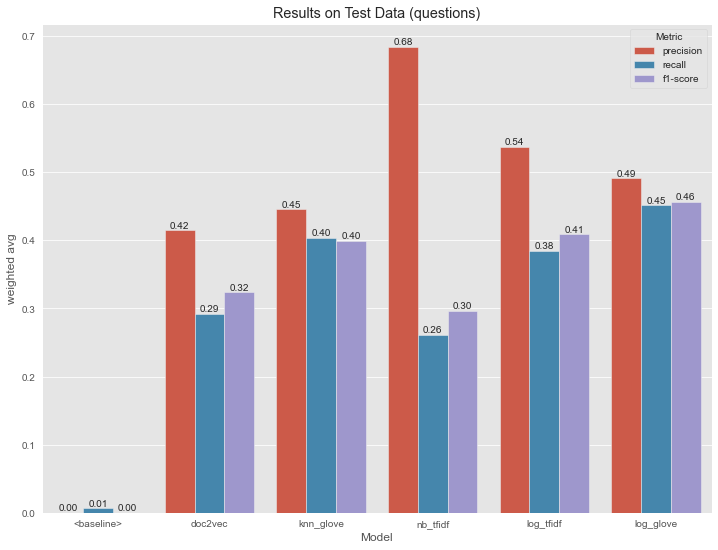

In [495]:
plt.figure(figsize=(12,9))
plt.style.use('ggplot')
ax = sns.barplot(data=plot_data, y='weighted avg', x='Model', hue='Metric')
for container in ax.containers:
    b = container
    ax.bar_label(container, fmt='%.2f')
ax.set(title='Results on Test Data (questions)')
plt.savefig('model-results.png')

In [50]:
matrix = metrics.confusion_matrix(test.title_id, log_clf.predict(vecs))

In [255]:
# plt.figure(figsize=(16, 9))

# _arr = np.where(matrix == 0, np.nan, np.tril(matrix, k=-1))
# sns.heatmap(_arr, cmap='rocket_r')

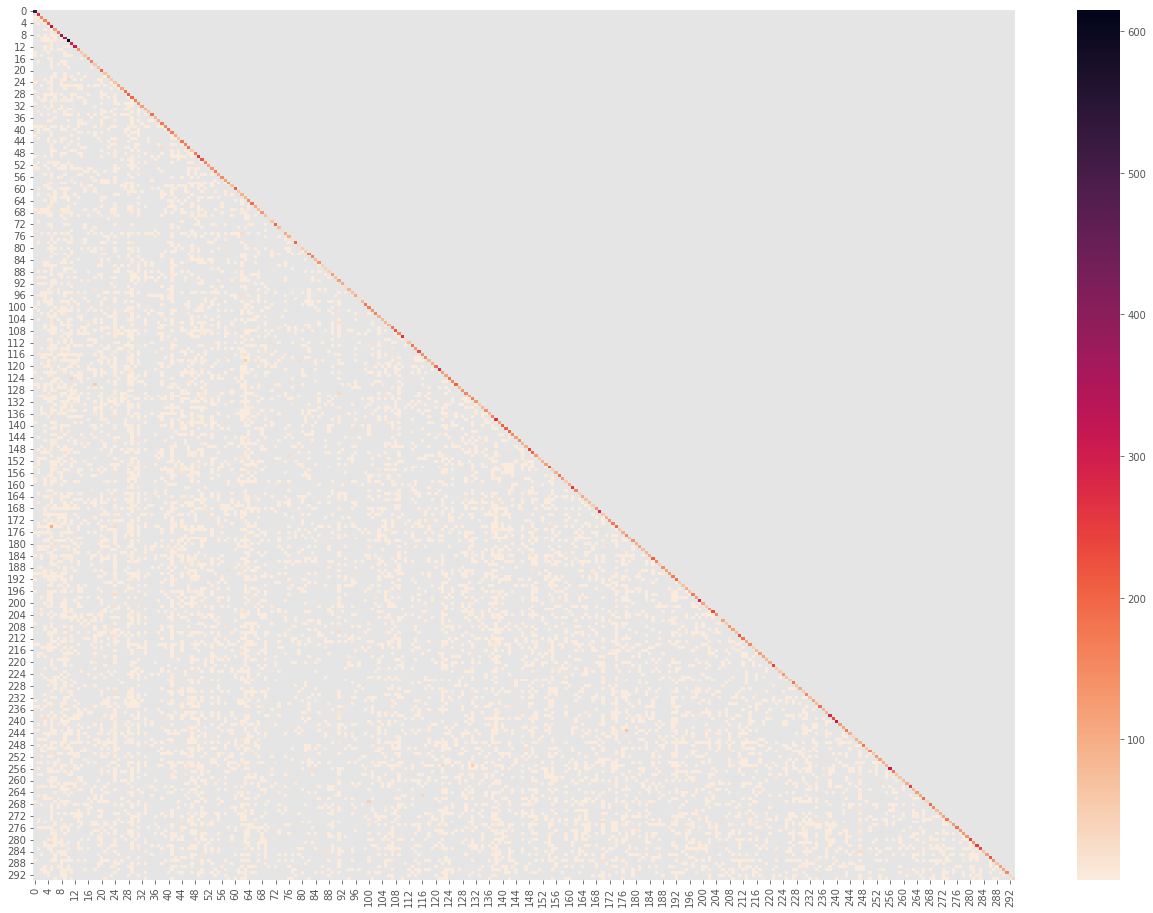

In [55]:
plt.figure(figsize=(22, 16))
arr = np.tril(matrix, k=0)
sns.heatmap(np.where(arr == 0, np.nan, arr), cmap='rocket_r')
plt.savefig('confusion-heatmap.eps')

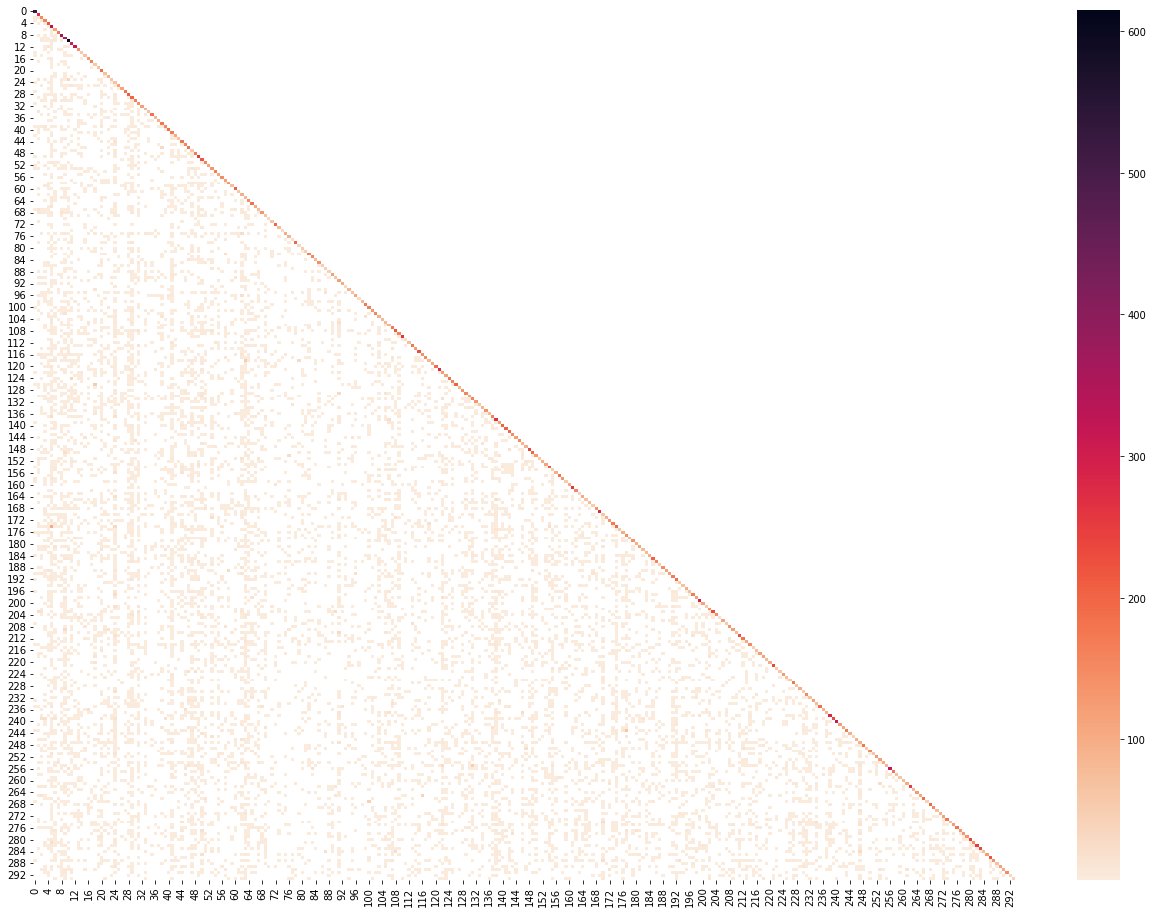

In [51]:
plt.figure(figsize=(22, 16))
arr = np.tril(matrix, k=0)
sns.heatmap(np.where(arr == 0, np.nan, arr), cmap='rocket_r')
plt.savefig('confusion-heatmap.png')

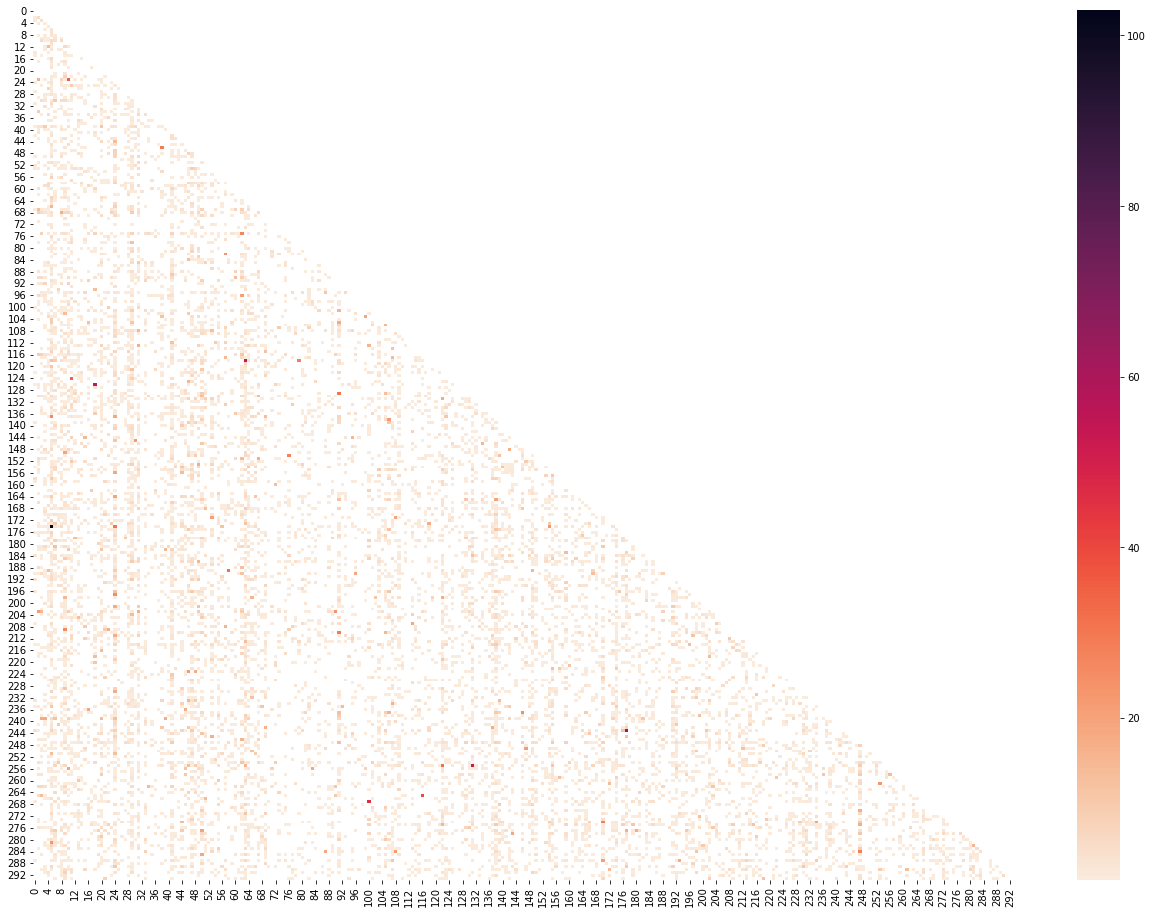

In [52]:
plt.figure(figsize=(22, 16))
arr = np.tril(matrix, k=-1)
sns.heatmap(np.where(arr == 0, np.nan, arr), cmap='rocket_r')
plt.savefig('confusion-heatmap-misclassification.png')